In [2]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import time


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Define dataset path
data_dir = r"C:\Users\ADMIN\Documents\Document\USTH\B3\luận tốt nghiệp\dataset\mango leaf dataset"

In [5]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])

In [6]:
# Load dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)

In [7]:
# Split dataset (80% train, 20% val)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
# Load a pre-trained model (ResNet18) and fine-tune
model = models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ADMIN/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 12.0MB/s]


In [9]:
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [10]:
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Epoch [1/5] - Loss: 0.1946, Accuracy: 0.9522
Epoch [2/5] - Loss: 0.0130, Accuracy: 0.9981
Epoch [3/5] - Loss: 0.0054, Accuracy: 0.9997
Epoch [4/5] - Loss: 0.0126, Accuracy: 0.9972
Epoch [5/5] - Loss: 0.0219, Accuracy: 0.9941


In [11]:
# Validation
model.eval()
y_true = []
y_pred = []

In [12]:
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [13]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
                  precision    recall  f1-score   support

     Anthracnose       1.00      1.00      1.00        98
Bacterial Canker       1.00      1.00      1.00        81
  Cutting Weevil       1.00      1.00      1.00        86
        Die Back       1.00      1.00      1.00       110
      Gall Midge       1.00      1.00      1.00       112
         Healthy       1.00      1.00      1.00       125
  Powdery Mildew       1.00      1.00      1.00        91
     Sooty Mould       1.00      1.00      1.00        97

        accuracy                           1.00       800
       macro avg       1.00      1.00      1.00       800
    weighted avg       1.00      1.00      1.00       800



In [14]:
# Save model
torch.save(model.state_dict(), "mango_leaf_model.pth")
print("Model saved as mango_leaf_model.pth")

Model saved as mango_leaf_model.pth


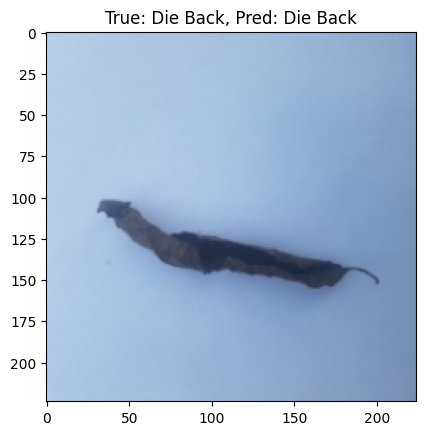

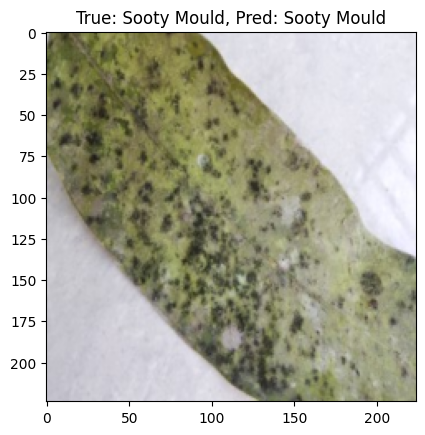

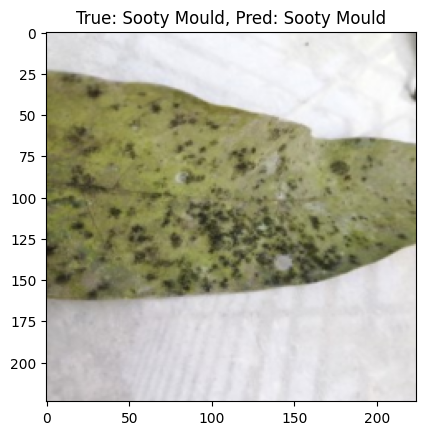

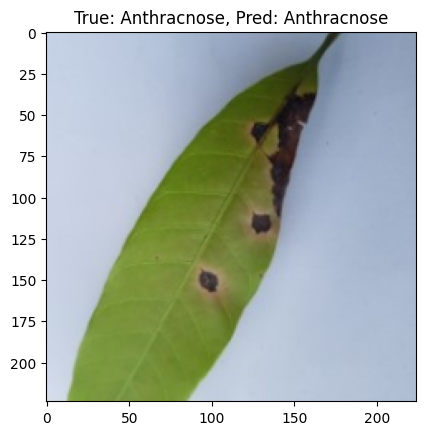

In [15]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = inp * 0.5 + 0.5  # unnormalize
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)

# Show 4 predictions from validation set
inputs, classes_ = next(iter(val_loader))
inputs = inputs[:4]
classes_ = classes_[:4]

model.eval()
outputs = model(inputs.to(device))
_, preds = torch.max(outputs, 1)

for i in range(4):
    imshow(inputs[i], title=f"True: {class_names[classes_[i]]}, Pred: {class_names[preds[i]]}")
